In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('mode.chained_assignment', None)
from sklearn.linear_model import LinearRegression
import random
from itertools import combinations

In [2]:
# loading raw csv data for 1st and 2nd ballot in each year

df1_2005 = pd.read_csv("./2005/1st-ballot-2005.csv")
df2_2005 = pd.read_csv("./2005/2nd-ballot-2005.csv")
df1_2010 = pd.read_csv("./2010/1st-ballot-2010.csv")
df2_2010 = pd.read_csv("./2010/2nd-ballot-2010.csv")
df1_2015 = pd.read_csv("./2015/1st-ballot-2015.csv")
df2_2015 = pd.read_csv("./2015/2nd-ballot-2015.csv")
df1_2020 = pd.read_csv("./2020/1st-ballot-2020.csv")

In [3]:
# adding turnout column to the data 

def add_turnout_column(df):
    df["turnout"] = df["total_votes"] / df["eligible_voters"]
    df = df[list(df.columns)[:4] + ["turnout"] + list(df.columns)[4:-1]]
    return df

df1_2005 = add_turnout_column(df1_2005) 
df2_2005 = add_turnout_column(df2_2005)
df1_2010 = add_turnout_column(df1_2010)
df2_2010 = add_turnout_column(df2_2010)
df1_2015 = add_turnout_column(df1_2015)
df2_2015 = add_turnout_column(df2_2015)
df1_2020 = add_turnout_column(df1_2020)

In [4]:
# adding % results of each candidate with respect to total voters and eligible voters

def add_perc_results(df):
    no_of_candidates = df.shape[1] - 5
    candidate_list = list(df.columns)[-no_of_candidates:]
    for candidate in candidate_list:
        df[candidate + "_votes_perc"] = df[candidate] / df["total_votes"]
        df[candidate + "_eligible_perc"] = df[candidate] / df["eligible_voters"]
    
    return df

df1_2005 = add_perc_results(df1_2005) 
df2_2005 = add_perc_results(df2_2005)
df1_2010 = add_perc_results(df1_2010)
df2_2010 = add_perc_results(df2_2010)
df1_2015 = add_perc_results(df1_2015)
df2_2015 = add_perc_results(df2_2015)
df1_2020 = add_perc_results(df1_2020)

In [5]:
# Adding the result of candidates, who didn't make it to the 2nd ballot

df1_2005["Other_eligible_perc"] = df1_2005["turnout"] - df1_2005["Kaczynski_eligible_perc"] - df1_2005["Tusk_eligible_perc"]
df1_2010["Other_eligible_perc"] = df1_2010["turnout"] - df1_2010["Kaczynski_eligible_perc"] - df1_2010["Komorowski_eligible_perc"]
df1_2015["Other_eligible_perc"] = df1_2015["turnout"] - df1_2015["Duda_eligible_perc"] - df1_2015["Komorowski_eligible_perc"]
df1_2020["Other_eligible_perc"] = df1_2020["turnout"] - df1_2020["Duda_eligible_perc"] - df1_2020["Trzaskowski_eligible_perc"]

df1_2005["Inactive_eligible_perc"] = 1 - df1_2005["turnout"] 
df1_2010["Inactive_eligible_perc"] = 1 - df1_2010["turnout"] 
df1_2015["Inactive_eligible_perc"] = 1 - df1_2015["turnout"] 
df1_2020["Inactive_eligible_perc"] = 1 - df1_2020["turnout"] 

In [8]:
# Given a set of candidates prepare n samples of train-test data

def generate_train_test(candidates, target_candidate, year, n_samples, train_size):
    
    columns = [f"{candidate}_eligible_perc" for candidate in candidates]
    
    dfs = {2005: [df1_2005, df2_2005],
           2010: [df1_2010, df2_2010],
           2015: [df1_2015, df2_2015]}
    
    df1, df2 = dfs[year]
    
    y = np.array(df2[f"{target_candidate}_eligible_perc"] - df1[f"{target_candidate}_eligible_perc"])
    X = np.array(df1[columns]) 
    
    indecies = [i for i in range(381)]
    train_indecies = []
    test_indecies = []
    
    for i in range(n_samples):
        random.shuffle(indecies)
        train_indecies.append(indecies[:train_size])
        test_indecies.append(indecies[train_size:])
        
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    
    for i in range(n_samples):
        X_train_list.append(X[train_indecies[i]])
        y_train_list.append(y[train_indecies[i]])
        X_test_list.append(X[test_indecies[i]])
        y_test_list.append(y[test_indecies[i]])
    
        
    return np.array(X_train_list), np.array(X_test_list), np.array(y_train_list), np.array(y_test_list)

# Calculating root mean squared error

def get_rmse(actual, predictions):
    return np.sqrt(np.mean((actual - predictions) ** 2))



def test_model_performance(train_test):
    
    X_train, X_test, y_train, y_test = train_test
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    model_error = get_rmse(y_test, predictions)
    
    return model_error, model


def find_increase_model(target_candidate, candidates, year, normalized=False):
    
    cols = [f"{candidate}_eligible_perc" for candidate in candidates]
    
    dfs = {2005: [df1_2005, df2_2005],
           2010: [df1_2010, df2_2010],
           2015: [df1_2015, df2_2015]}
    
    df1 = dfs[year][0]
    df2 = dfs[year][1]
    
    X = np.array(df1[cols])
    y = np.array(df2[f"{target_candidate}_eligible_perc"] - df1[f"{target_candidate}_eligible_perc"])
    
    
    X_train_list, X_test_list, y_train_list, y_test_list = generate_train_test(candidates, target_candidate, year, 500, 250)
    models = []
    
    if normalized:
        X /= X.mean(axis=0)
        X_train_list /= X_train_list.mean(axis=1)[:, np.newaxis]
        X_test_list /= X_test_list.mean(axis=1)[:, np.newaxis]
    
    
    for sample in range(500):
        X_train = X_train_list[sample]
        X_test = X_test_list[sample]
        y_train = y_train_list[sample]
        y_test = y_test_list[sample]
        
        train_test_data = (X_train, X_test, y_train, y_test)
        new_model = test_model_performance(train_test_data)[1]
            
        models.append(new_model)
    
    models = np.array([np.append(models[s].intercept_, models[s].coef_) for s in range(500)])
    mean_model = np.mean(models, axis=0)
    std_model = np.std(models, axis=0)
    
    return mean_model, std_model

In [156]:
runoff_list = [("Tusk", ["Tusk", "Other"], 2005),
               ("Komorowski", ["Komorowski", "Other"], 2010),
               ("Komorowski", ["Komorowski", "Other"], 2015),
               ("Kaczynski", ["Kaczynski", "Other"], 2005),
               ("Kaczynski", ["Kaczynski", "Other"], 2010),
               ("Duda", ["Duda", "Other"], 2015)]

for run in runoff_list:
    mean_model, std_model = find_increase_model(*run)
    mean_model, std_model = np.round(mean_model, 3), np.round(std_model, 3)
    print(f"{run[0]}, {run[-1]} increase = {mean_model[0]}({std_model[0]}) + OWN x {mean_model[1]}({std_model[1]}) + OTHER x {mean_model[2]}({std_model[2]})")
    print("")

Tusk, 2005 increase = -0.041(0.005) + OWN x 0.329(0.021) + OTHER x 0.238(0.019)

Komorowski, 2010 increase = 0.02(0.007) + OWN x 0.092(0.013) + OTHER x 0.206(0.046)

Komorowski, 2015 increase = 0.001(0.004) + OWN x 0.536(0.013) + OTHER x 0.084(0.032)

Kaczynski, 2005 increase = -0.106(0.01) + OWN x 0.423(0.049) + OTHER x 0.994(0.026)

Kaczynski, 2010 increase = -0.045(0.006) + OWN x 0.257(0.011) + OTHER x 0.481(0.044)

Duda, 2015 increase = -0.006(0.008) + OWN x 0.474(0.009) + OTHER x 0.267(0.06)



In [119]:
po = np.array([0.001, 0.537, 0.086])
pis = np.array([-0.006, 0.474, 0.267])

first_ballot = np.array(df1_2015[["Komorowski_eligible_perc", "Duda_eligible_perc", "Other_eligible_perc"]])
duda_expected = np.array(df1_2015["Duda_eligible_perc"]) + pis[0] + np.dot(first_ballot[:, 1:], pis[1:])
komor_expected = np.array(df1_2015["Komorowski_eligible_perc"]) + po[0] + np.dot(first_ballot[:, [0,2]], po[1:])

duda_total = np.dot(duda_expected, df1_2015["eligible_voters"])
komor_total = np.dot(komor_expected, df1_2015["eligible_voters"])
expected_total = duda_total + komor_total
eligible = df1_2015["eligible_voters"].sum()
print("EXPECTED RESULTS:")
print(f"Duda expected: {int(duda_total)}   -   {np.round(100 * duda_total / expected_total, 2)}%")
print(f"Komor expected: {int(komor_total)}   -   {np.round(100 * komor_total / expected_total, 2)}%")
print(f"Turnout: {np.round(100 * expected_total / eligible, 2)}%")

duda_true = df2_2015["Duda"].sum()
komor_true = df2_2015["Komorowski"].sum()
total_true = duda_true + komor_true
eligible = df2_2015["eligible_voters"].sum()

print("\nACTUAL RESULTS:")
print(f"Duda true: {int(duda_true)}   -   {np.round(100 * duda_true / total_true, 2)}%")
print(f"Komor true: {int(komor_true)}   -   {np.round(100 * komor_true / total_true, 2)}%")
print(f"Turnout: {np.round(100 * total_true / eligible, 2)}%")

EXPECTED RESULTS:
Duda expected: 8701754   -   51.59%
Komor expected: 8166663   -   48.41%
Turnout: 54.97%

ACTUAL RESULTS:
Duda true: 8630627   -   51.55%
Komor true: 8112311   -   48.45%
Turnout: 54.52%


In [168]:
po = np.array([-0.03, 0.65, 0.225])
pis = np.array([-0.055, 0.225, 0.275])

first_ballot = np.array(df1_2020[["Trzaskowski_eligible_perc", "Duda_eligible_perc", "Other_eligible_perc"]])
pis_expected = np.array(df1_2020["Duda_eligible_perc"]) + pis[0] + np.dot(first_ballot[:, 1:], pis[1:])
po_expected = np.array(df1_2020["Trzaskowski_eligible_perc"]) + po[0] + np.dot(first_ballot[:, [0,2]], po[1:])
expected_total = np.sum(pis_expected + po_expected)

pis_total = np.dot(pis_expected, df1_2020["eligible_voters"])
po_total = np.dot(po_expected, df1_2020["eligible_voters"])
expected_total = pis_total + po_total
eligible = df1_2020["eligible_voters"].sum()

print("EXPECTED RESULTS:")
print(f"Duda expected: {int(pis_total)}   -   {np.round(100 * pis_total / expected_total, 2)}%")
print(f"Trzask expected: {int(po_total)}   -   {np.round(100 * po_total / expected_total, 2)}%")
print(f"Turnout: {np.round(100 * expected_total / eligible, 2)}%")

EXPECTED RESULTS:
Duda expected: 10081462   -   50.21%
Trzask expected: 9995431   -   49.79%
Turnout: 66.47%


In [157]:
po_0 = np.linspace(-0.04, -0.02, 8)
po_1 = np.linspace(0.5, 0.7, 8)
po_2 = np.linspace(0.15, 0.3, 8)

pis_0 = np.linspace(-0.07, -0.04, 8)
pis_1 = np.linspace(0.15, 0.30, 8)
pis_2 = np.linspace(0.2, 0.35, 8)

In [158]:
po_vectors = []
for x0 in po_0:
    for x1 in po_1:
        for x2 in po_2:
            po_vectors.append(np.array([x0, x1, x2]))
                
pis_vectors = []
for x0 in pis_0:
    for x1 in pis_1:
        for x2 in pis_2:
            pis_vectors.append(np.array([x0, x1, x2]))                

In [159]:
pis_votes = []
po_votes = []
turnouts = []

c = 0

for po_vec in po_vectors:
    for pis_vec in pis_vectors:
        
        first_ballot = np.array(df1_2020[["Trzaskowski_eligible_perc", "Duda_eligible_perc", "Other_eligible_perc"]])
        pis_expected = np.array(df1_2020["Duda_eligible_perc"]) + pis_vec[0] + np.dot(first_ballot[:, 1:], pis_vec[1:])
        po_expected = np.array(df1_2020["Trzaskowski_eligible_perc"]) + po_vec[0] + np.dot(first_ballot[:, [0,2]], po_vec[1:])
        expected_total = np.sum(pis_expected + po_expected)
        
        pis_total = np.dot(pis_expected, df1_2020["eligible_voters"])
        po_total = np.dot(po_expected, df1_2020["eligible_voters"])
        expected_total = duda_total + komor_total
        
        pis_votes.append(pis_total)
        po_votes.append(po_total)
        turnouts.append(expected_total)
        
        c += 1
        
        if c % 1000 == 0:
            print(c, end='\r')

pis_votes = np.array(pis_votes)
po_votes = np.array(po_votes)
turnouts = pis_votes + po_votes

pis_perc = pis_votes / turnouts
po_perc = po_votes / turnouts

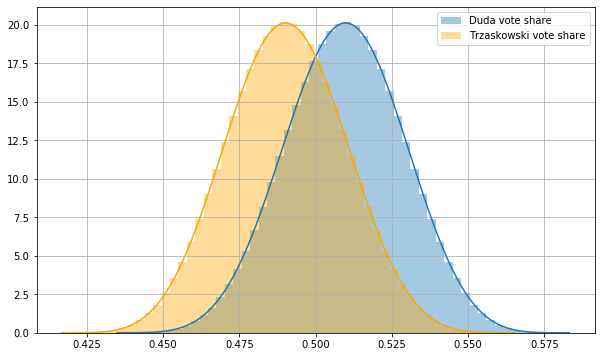

In [176]:
plt.figure(figsize=(10,6))
sns.distplot(pis_perc, label="Duda vote share")
sns.distplot(po_perc, color="orange", label="Trzaskowski vote share")
plt.legend()
plt.grid()
plt.show()

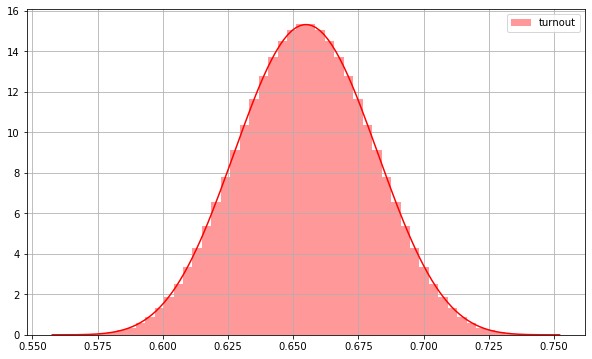

In [175]:
plt.figure(figsize=(10,6))
sns.distplot(turnouts / eligible, color="red", label="turnout")
plt.grid()
plt.legend()
plt.show()

In [161]:
print(np.median(pis_perc), np.std(pis_perc))
print(np.median(po_perc), np.std(po_perc))
print(pis_perc[pis_perc > 0.5].shape[0] / len(pis_perc))

0.509653127440169 0.019116976113345074
0.490346872559831 0.019116976113345077
0.6875648498535156


In [162]:
eligible = df1_2020["eligible_voters"].sum()
print(np.mean(turnouts / eligible), np.std(turnouts / eligible))

0.6548993290245977 0.02505292307819001


In [177]:
print(f"Duda total votes: {round(np.mean(turnouts) * np.median(pis_perc))} ({np.round(100 * np.median(pis_perc), 2)}%)")
print(f"Trzaskowski total votes: {round(np.mean(turnouts) * np.median(po_perc))} ({np.round(100 * np.median(po_perc), 2)}%)")

Duda total votes: 10081462.0 (50.97%)
Trzaskowski total votes: 9699565.0 (49.03%)
